<h1> Spirometer classification </h1>

This python notebook transforms the input data available in the github repository and test it with multiple classification algorithms to find out which on fits better.

<h3> Libraries </h3>

In [1]:
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
import matplotlib.pyplot as plt # for plotting
from matplotlib import cm
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

from pycm import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
#CSV data file load
audio_features = pd.read_csv("Audios/Caracteristiques_20211004.csv",sep=";",decimal=',')

#Values transformation into numeric values
audio_features['sex'].mask(audio_features['sex'] == 'H', 1, inplace=True)
audio_features['sex'].mask(audio_features['sex'] == 'M', 0, inplace=True)

audio_features["sex"] = audio_features["sex"].astype(np.float64)
audio_features["age"] = audio_features["age"].astype(np.float64)

audio_features =audio_features.drop("Inf_Mut",axis=1)

#Remove outliers
audio_features.drop(audio_features[audio_features["age"]>74].index, inplace=True)

#Join age features in groups
audio_features['age'].mask(audio_features['age'] < 20, 1, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(25) & audio_features['age'].ge(20), 2, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(30) & audio_features['age'].ge(25), 3, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(35) & audio_features['age'].ge(30), 4, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(40) & audio_features['age'].ge(35), 5, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(45) & audio_features['age'].ge(40), 6, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(50) & audio_features['age'].ge(45), 7, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(55) & audio_features['age'].ge(50), 8, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(60) & audio_features['age'].ge(55), 9, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(65) & audio_features['age'].ge(60), 10, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(70) & audio_features['age'].ge(65), 11, inplace=True)
audio_features['age'].mask(audio_features['age'].lt(75) & audio_features['age'].ge(70), 12, inplace=True)

<h3> Corellation </h3>
In this section we check the correlation 1 by 1 feature as a diagnostic when checking other analyses.

In [3]:
cor_matrix = audio_features.loc[:, audio_features.columns != 'age'].corr().abs()

In [4]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
from IPython.core.display import HTML
display(HTML(upper_tri.to_html()))

,f_Cres1,f_Cres2,f_Cres3,f_Cres4,f_Cres5,f_Cres6,f_Cres7,Enr_Bn1,Enr_Bn2,Enr_Bn3,Enr_Bn4,Enr_Bn5,Enr_Bn6,Enr_Bn7,f_Med1,f_Med2,f_Med3,f_Med4,f_Med5,f_Med6,f_Med7,IE_Bn1,IE_Bn2,IE_Bn3,IE_Bn4,IE_Bn5,IE_Bn6,IE_Bn7,H_tf,H_t,H_f,fm,kurt_Mgt,MomC_11,MomC_77,MomC_1515,MomM_11,MomM_77,MomM_1515,sex,max_db,total_db,total_db_1_sec
f_Cres1,NaN,0.024547,0.096480,0.081980,0.007710,0.139975,0.136188,0.274204,0.358709,0.278845,0.127198,0.070878,0.058840,0.396105,0.777010,0.029479,0.218207,0.182467,0.093156,0.080088,0.169936,0.235277,0.571545,0.518226,0.326053,0.214478,0.068338,0.019102,0.202861,0.200071,0.261931,0.396690,0.013303,0.031087,0.134577,0.217801,0.033281,0.010483,0.014840,0.031442,0.070752,0.208333,0.142983
f_Cres2,NaN,NaN,0.075614,0.149475,0.023243,0.020610,0.241600,0.241658,0.202005,0.311574,0.231075,0.166435,0.054033,0.146053,0.043162,0.779631,0.076763,0.067569,0.028277,0.015411,0.331011,0.167631,0.000550,0.267455,0.306537,0.240439,0.210401,0.159179,0.231954,0.005376,0.247282,0.041749,0.114890,0.075179,0.061765,0.057473,0.018424,0.019425,0.007676,0.020184,0.085999,0.071661,0.085063
f_Cres3,NaN,NaN,NaN,0.257811,0.188796,0.079085,0.288014,0.135283,0.538611,0.155284,0.360042,0.532632,0.375775,0.018971,0.010848,0.040600,0.770123,0.145135,0.125897,0.113666,0.389309,0.262665,0.278750,0.010561,0.273749,0.394195,0.380151,0.264687,0.339340,0.071210,0.327401,0.293005,0.072602,0.114805,0.173606,0.128853,0.078241,0.113880,0.105645,0.000704,0.167958,0.021010,0.010343
f_Cres4,NaN,NaN,NaN,NaN,0.035815,0.066247,0.232819,0.139169,0.303429,0.140384,0.271746,0.303370,0.325830,0.047889,0.022872,0.066227,0.178117,0.729885,0.104628,0.068324,0.360073,0.045461,0.033567,0.060829,0.313603,0.417717,0.393128,0.292507,0.402755,0.078706,0.400095,0.165031,0.052012,0.004262,0.073328,0.047924,0.028055,0.025008,0.027439,0.082481,0.170696,0.066171,0.049610
f_Cres5,NaN,NaN,NaN,NaN,NaN,0.077768,0.282188,0.180308,0.026186,0.153556,0.035234,0.128579,0.249692,0.018863,0.110973,0.010279,0.123186,0.126740,0.747320,0.042091,0.353278,0.159947,0.047749,0.006410,0.006019,0.094354,0.201932,0.085855,0.071396,0.202687,0.146887,0.120830,0.000873,0.052567,0.067198,0.040525,0.017050,0.031697,0.067155,0.003398,0.204408,0.150841,0.072906
f_Cres6,NaN,NaN,NaN,NaN,NaN,NaN,0.071969,0.013592,0.107743,0.286984,0.115867,0.107575,0.115241,0.514994,0.252780,0.056873,0.082882,0.016557,0.085345,0.720799,0.010658,0.253701,0.324661,0.449036,0.456156,0.360314,0.007151,0.038656,0.186257,0.064709,0.196833,0.459353,0.020902,0.012486,0.108724,0.194837,0.038572,0.020081,0.029553,0.000928,0.153558,0.107164,0.145100
f_Cres7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340833,0.344922,0.048182,0.246521,0.346396,0.422540,0.010590,0.190323,0.212116,0.293112,0.207535,0.300454,0.104108,0.793362,0.323783,0.122715,0.050740,0.229397,0.396691,0.491521,0.246018,0.392475,0.031056,0.418487,0.244394,0.088987,0.140232,0.168286,0.162176,0.076070,0.015514,0.023643,0.041326,0.307609,0.117700,0.029264
Enr_Bn1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070919,0.259034,0.210402,0.248534,0.241825,0.088310,0.229822,0.355954,0.128232,0.096515,0.100053,0.060011,0.469572,0.312837,0.084600,0.252124,0.268155,0.274378,0.205977,0.061222,0.453519,0.169616,0.498394,0.114953,0.131149,0.031627,0.139185,0.117397,0.132431,0.161808,0.039923,0.024675,0.054510,0.386464,0.237378
Enr_Bn2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112398,0.378892,0.501808,0.546887,0.384081,0.389281,0.157367,0.661693,0.328391,0.117975,0.026092,0.351580,0.407133,0.650110,0.297045,0.123159,0.321382,0.452011,0.311329,0.335593,0.235568,0.294597,0.685262,0.095228,0.022190,0.326956,0.319106,0.007337,0.012508,0.014514,0.061187,0.245516,0.262177,0.159229
Enr_Bn3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028140,0.274051,0.328589,0.347559,0.199507,0.337838,0.158457,0.291870,0.209496,0.181198,0.014407,0.201132,0.363764,0.571400,0.286506,0.047533,0.089530,0.084170,0.106738,0.101442,0.120905,0.438441,0.028388,0.048181,0.115988,0.143085,0.021093,0.040286,0.039808,0.024219,0.194380,0.007378,0.120008


In [5]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print("Variables to drop:",to_drop)

Variables to drop: ['H_f']


In [6]:
audio_features=audio_features.drop(to_drop,axis=1)

<h3> PCA </h3>
We apply the PCA algorithm do determine the most important components of all de data-set

In [7]:
df = audio_features.filter(audio_features.columns[:])
df = df.loc[:, df.columns != 'age']

X = df.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

pca = PCA()
X_pca = pca.fit(X_std)

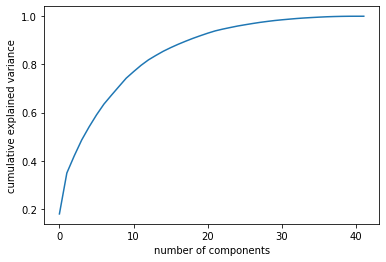

In [8]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
num_components = len(df.columns)
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

In [10]:
pca = PCA(n_components = 0.999)
X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions
print(pca.n_components_) # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5

39


In [11]:
pca.explained_variance_ratio_

array([0.17980027, 0.16968025, 0.07142519, 0.06564169, 0.05445411,
       0.04983188, 0.04474501, 0.03652538, 0.03569004, 0.03531003,
       0.02725706, 0.02608772, 0.02264205, 0.01843313, 0.01735092,
       0.01502149, 0.0138275 , 0.01269719, 0.01204683, 0.01097538,
       0.0104578 , 0.00945748, 0.00726989, 0.00648963, 0.00623693,
       0.00530318, 0.00506101, 0.00472655, 0.00405349, 0.00373675,
       0.00304838, 0.00276667, 0.00263466, 0.00217399, 0.00180829,
       0.00165054, 0.00145424, 0.00099836, 0.00075607])

In [12]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df.columns
print(initial_feature_names)
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names = np.unique(most_important_names)
print(np.unique(most_important_names))

Index(['f_Cres1', 'f_Cres2', 'f_Cres3', 'f_Cres4', 'f_Cres5', 'f_Cres6',
       'f_Cres7', 'Enr_Bn1', 'Enr_Bn2', 'Enr_Bn3', 'Enr_Bn4', 'Enr_Bn5',
       'Enr_Bn6', 'Enr_Bn7', 'f_Med1', 'f_Med2', 'f_Med3', 'f_Med4', 'f_Med5',
       'f_Med6', 'f_Med7', 'IE_Bn1', 'IE_Bn2', 'IE_Bn3', 'IE_Bn4', 'IE_Bn5',
       'IE_Bn6', 'IE_Bn7', 'H_tf', 'H_t', 'fm', 'kurt_Mgt', 'MomC_11',
       'MomC_77', 'MomC_1515', 'MomM_11', 'MomM_77', 'MomM_1515', 'sex',
       'max_db', 'total_db', 'total_db_1_sec'],
      dtype='object')
['Enr_Bn2' 'Enr_Bn3' 'Enr_Bn5' 'Enr_Bn6' 'H_t' 'H_tf' 'IE_Bn2' 'IE_Bn3'
 'IE_Bn5' 'IE_Bn7' 'MomC_11' 'MomC_77' 'MomM_11' 'MomM_77' 'f_Cres2'
 'f_Cres3' 'f_Cres4' 'f_Cres5' 'f_Cres6' 'f_Med1' 'f_Med2' 'f_Med4'
 'f_Med5' 'f_Med6' 'f_Med7' 'kurt_Mgt' 'max_db' 'sex' 'total_db']


<h3> SMOTE </h3>
This algorithm is applied in order to improve and balance de data-set

In [13]:
y = audio_features['age']

feature_names = audio_features.filter(most_important_names)
X = audio_features.filter(feature_names)

print(Counter(y))

oversample = SMOTE(random_state=42,k_neighbors=1)
X, y = oversample.fit_resample(X, y)
counter=Counter(y)

print(counter)



Counter({9.0: 41, 2.0: 20, 3.0: 19, 5.0: 18, 6.0: 15, 4.0: 14, 7.0: 14, 8.0: 14, 10.0: 12, 11.0: 11, 1.0: 10})
Counter({1.0: 41, 2.0: 41, 3.0: 41, 4.0: 41, 5.0: 41, 6.0: 41, 7.0: 41, 8.0: 41, 9.0: 41, 10.0: 41, 11.0: 41})


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
'''
import warnings
warnings.filterwarnings('ignore')
'''

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter=10000),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    pred = clf.predict(X_test)
    precision,recall,fscore,support=score(y_test,pred,average='macro')
    
    mcm=multilabel_confusion_matrix(y_test, pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    
    print("Accuracy\tSpecificity\tSensitivity")
    print("{:.4}\t".format(acc*100).replace('.',','),"\t","{:.4}".format(recall*100).replace('.',','),"\t\t","{:.4}".format(((tn / (tn + fp))*100).mean()).replace('.',','))


KNeighborsClassifier
Accuracy	Specificity	Sensitivity
54,87	 	 60,26 		 95,5
SVC
Accuracy	Specificity	Sensitivity
4,425	 	 9,091 		 90,91
DecisionTreeClassifier
Accuracy	Specificity	Sensitivity
59,29	 	 65,69 		 95,9
RandomForestClassifier
Accuracy	Specificity	Sensitivity
78,76	 	 81,39 		 97,89
AdaBoostClassifier
Accuracy	Specificity	Sensitivity
16,81	 	 20,73 		 91,77
GradientBoostingClassifier
Accuracy	Specificity	Sensitivity
63,72	 	 66,25 		 96,38
GaussianNB
Accuracy	Specificity	Sensitivity
42,48	 	 47,11 		 94,24
LogisticRegression
Accuracy	Specificity	Sensitivity
38,05	 	 43,87 		 93,91
LinearDiscriminantAnalysis
Accuracy	Specificity	Sensitivity
50,44	 	 53,86 		 95,05
QuadraticDiscriminantAnalysis
Accuracy	Specificity	Sensitivity
94,69	 	 94,45 		 99,45


<h3> Logistic Regresion </h3>

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

pred = logreg.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))



Accuracy of Logistic regression classifier on training set: 0.53
Accuracy of Logistic regression classifier on test set: 0.38
[[7 1 0 0 0 0 1 0 0 0 0]
 [0 4 0 4 2 1 1 0 1 2 1]
 [0 0 2 2 4 0 1 0 1 0 0]
 [0 0 0 4 0 0 0 0 1 1 1]
 [0 0 0 1 1 2 0 0 0 2 1]
 [0 0 0 1 1 4 0 0 0 0 0]
 [0 2 0 2 0 0 6 0 0 1 3]
 [3 0 1 0 1 3 0 4 0 4 0]
 [3 0 2 1 1 2 1 1 1 2 0]
 [0 0 0 0 0 0 0 0 0 4 1]
 [1 1 0 1 0 0 0 0 0 0 6]]
              precision    recall  f1-score   support

         1.0       0.50      0.78      0.61         9
         2.0       0.50      0.25      0.33        16
         3.0       0.40      0.20      0.27        10
         4.0       0.25      0.57      0.35         7
         5.0       0.10      0.14      0.12         7
         6.0       0.33      0.67      0.44         6
         7.0       0.60      0.43      0.50        14
         8.0       0.80      0.25      0.38        16
         9.0       0.25      0.07      0.11        14
        10.0       0.25      0.80      0.38         5
   

<h3> Decision Tree</h3>

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.60
Accuracy: 0.6017699115044248
[[ 8  1  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  1  1  1  0  2  1  2]
 [ 0  1  6  0  1  0  1  1  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  1  0]
 [ 0  1  0  1  4  0  0  0  1  0  0]
 [ 0  0  0  0  1  5  0  0  0  0  0]
 [ 2  0  0  1  1  0  9  0  0  1  0]
 [ 0  1  1  0  0  1  1 10  1  1  0]
 [ 1  1  2  0  2  3  1  2  0  1  1]
 [ 1  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  1  0  0  0  0  0  0  8]]
              precision    recall  f1-score   support

         1.0       0.67      0.89      0.76         9
         2.0       0.62      0.50      0.55        16
         3.0       0.67      0.60      0.63        10
         4.0       0.67      0.86      0.75         7
         5.0       0.40      0.57      0.47         7
         6.0       0.50      0.83      0.62         6
         7.0       0.69      0.64      0.67        14
         8.0       0.77    

<h3> Random Forests </h3>

In [18]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight="balanced",n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(RF.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(RF.score(X_test, y_test)))

pred = RF.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of GNB classifier on training set: 0.61
Accuracy of GNB classifier on test set: 0.34
[[9 0 0 0 0 0 0 0 0 0 0]
 [4 0 1 2 3 1 1 0 1 1 2]
 [0 0 3 0 2 2 1 0 0 0 2]
 [1 0 0 4 0 0 0 0 0 2 0]
 [0 0 0 0 2 2 0 0 1 2 0]
 [0 0 0 0 1 4 0 0 1 0 0]
 [3 0 0 0 2 3 4 0 0 1 1]
 [4 0 2 0 0 1 1 1 0 4 3]
 [0 0 1 1 1 5 2 0 1 3 0]
 [1 0 0 0 0 0 0 0 0 4 0]
 [2 0 0 0 1 0 0 0 0 0 6]]
              precision    recall  f1-score   support

         1.0       0.38      1.00      0.55         9
         2.0       0.00      0.00      0.00        16
         3.0       0.43      0.30      0.35        10
         4.0       0.57      0.57      0.57         7
         5.0       0.17      0.29      0.21         7
         6.0       0.22      0.67      0.33         6
         7.0       0.44      0.29      0.35        14
         8.0       1.00      0.06      0.12        16
         9.0       0.25      0.07      0.11        14
        10.0       0.24      0.80      0.36         5
        11.0       0.43      0.67  

<h3> K-Nearest Neighbors </h3>

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of K-NN classifier on training set: 0.73
Accuracy of K-NN classifier on test set: 0.55
[[ 8  1  0  0  0  0  0  0  0  0  0]
 [ 1  4  3  1  6  1  0  0  0  0  0]
 [ 0  1  9  0  0  0  0  0  0  0  0]
 [ 1  0  1  4  0  0  0  0  0  1  0]
 [ 0  0  1  1  4  0  0  0  0  1  0]
 [ 0  0  0  0  0  5  0  0  0  0  1]
 [ 1  1  0  0  1  1  7  1  0  1  1]
 [ 0  0  1  0  1  0  3 10  0  1  0]
 [ 1  2  3  1  1  2  1  3  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  3  0]
 [ 0  0  1  0  0  0  0  0  0  0  8]]
              precision    recall  f1-score   support

         1.0       0.62      0.89      0.73         9
         2.0       0.44      0.25      0.32        16
         3.0       0.47      0.90      0.62        10
         4.0       0.50      0.57      0.53         7
         5.0       0.31      0.57      0.40         7
         6.0       0.56      0.83      0.67         6
         7.0       0.64      0.50      0.56        14
         8.0       0.71      0.62      0.67        16
         9.0       0

<h3> Linear Discriminant Analysis </h3>

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

pred = lda.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of LDA classifier on training set: 0.66
Accuracy of LDA classifier on test set: 0.50
[[ 8  0  0  0  0  0  0  0  1  0  0]
 [ 0  7  0  4  1  0  0  0  3  0  1]
 [ 0  0  3  1  3  1  0  0  2  0  0]
 [ 0  0  0  3  0  0  0  1  2  1  0]
 [ 0  0  1  1  3  0  0  0  1  1  0]
 [ 0  0  0  0  0  4  0  0  2  0  0]
 [ 0  5  1  0  0  0  6  0  1  1  0]
 [ 1  0  0  0  2  1  0 10  1  1  0]
 [ 0  0  3  1  2  2  0  1  2  2  1]
 [ 1  0  0  0  0  0  0  0  0  4  0]
 [ 1  0  0  0  0  0  1  0  0  0  7]]
              precision    recall  f1-score   support

         1.0       0.73      0.89      0.80         9
         2.0       0.58      0.44      0.50        16
         3.0       0.38      0.30      0.33        10
         4.0       0.30      0.43      0.35         7
         5.0       0.27      0.43      0.33         7
         6.0       0.50      0.67      0.57         6
         7.0       0.86      0.43      0.57        14
         8.0       0.83      0.62      0.71        16
         9.0       0.1

<h3> Gaussian Naive Bayes</h3>

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Accuracy of GNB classifier on training set: 0.51
Accuracy of GNB classifier on test set: 0.42
[[ 9  0  0  0  0  0  0  0  0  0  0]
 [ 3  5  1  3  2  1  0  1  0  0  0]
 [ 0  1  2  0  0  3  0  0  4  0  0]
 [ 0  0  2  2  0  1  0  1  0  1  0]
 [ 1  0  0  1  4  1  0  0  0  0  0]
 [ 0  0  0  0  2  4  0  0  0  0  0]
 [ 1  4  2  0  0  3  2  1  0  0  1]
 [ 0  2  1  0  0  2  0 11  0  0  0]
 [ 0  3  1  2  4  1  1  1  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  4  0]
 [ 0  2  2  0  0  0  0  0  1  0  4]]
              precision    recall  f1-score   support

         1.0       0.60      1.00      0.75         9
         2.0       0.29      0.31      0.30        16
         3.0       0.18      0.20      0.19        10
         4.0       0.25      0.29      0.27         7
         5.0       0.33      0.57      0.42         7
         6.0       0.25      0.67      0.36         6
         7.0       0.67      0.14      0.24        14
         8.0       0.73      0.69      0.71        16
         9.0       0.1

<h3> Support Vector Machine </h3>

In [22]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.72
Accuracy of SVM classifier on test set: 0.54
[[8 1 0 0 0 0 0 0 0 0 0]
 [0 5 1 3 3 1 0 0 1 1 1]
 [0 0 6 0 2 0 0 0 2 0 0]
 [0 0 0 6 0 0 0 0 0 0 1]
 [0 0 2 1 3 0 0 0 0 1 0]
 [0 0 0 1 1 4 0 0 0 0 0]
 [2 1 0 0 1 1 6 0 2 1 0]
 [1 0 3 0 1 2 0 9 0 0 0]
 [1 0 2 2 1 3 1 0 3 1 0]
 [1 0 0 0 0 0 0 0 0 4 0]
 [1 0 1 0 0 0 0 0 0 0 7]]
              precision    recall  f1-score   support

         1.0       0.57      0.89      0.70         9
         2.0       0.71      0.31      0.43        16
         3.0       0.40      0.60      0.48        10
         4.0       0.46      0.86      0.60         7
         5.0       0.25      0.43      0.32         7
         6.0       0.36      0.67      0.47         6
         7.0       0.86      0.43      0.57        14
         8.0       1.00      0.56      0.72        16
         9.0       0.38      0.21      0.27        14
        10.0       0.50      0.80      0.62         5
        11.0       0.78      0.78  

<h3> QDA </h3>

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()
qda.fit(X_train, y_train)
print('Accuracy of QDA classifier on training set: {:.2f}'
     .format(qda.score(X_train, y_train)))
print('Accuracy of QDA classifier on test set: {:.2f}'
     .format(qda.score(X_test, y_test)))

pred = qda.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of QDA classifier on training set: 1.00
Accuracy of QDA classifier on test set: 0.95
[[ 9  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  2  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  1  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  2  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  0  0  1  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  9]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         9
         2.0       1.00      0.88      0.93        16
         3.0       1.00      1.00      1.00        10
         4.0       1.00      1.00      1.00         7
         5.0       1.00      0.86      0.92         7
         6.0       1.00      1.00      1.00         6
         7.0       1.00      0.86      0.92        14
         8.0       1.00      1.00      1.00        16
         9.0       0.7